In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets

In [2]:
cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


In [3]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print("Available")
  dev = torch.device('cuda')
  print(dev)

Available
cuda


In [0]:
# train_loader = torch.utils.data.DataLoader(
#   datasets.MNIST('', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                torchvision.transforms.Normalize(
#                                  (0.5,), (0.5,))
#                              ])),
#   batch_size=500, shuffle=True)
data = np.load("mnist_train_images.npy")

In [0]:
class RBM(torch.nn.Module):
  
  def __init__(self, v_size=784, h_size=256, k=1, lr=0.1):
    super(RBM, self).__init__()
    self.v = torch.Tensor(torch.randn(1, v_size)).to(dev)
    self.h = torch.Tensor(torch.randn(1, h_size)).to(dev)
    self.W = torch.Tensor(torch.randn(h_size, v_size)).to(dev)
    self.v_bias = torch.Tensor(torch.zeros(1, v_size)).to(dev)
    self.h_bias = torch.Tensor(torch.zeros(1, h_size)).to(dev)
    self.k = k
    self.lr = lr

  def sample_h_given_v(self, vis):
    htensor = torch.matmul(vis, self.W.T) + self.h_bias
    activation = torch.sigmoid(htensor)
    h_dist = torch.distributions.Bernoulli(activation)
    sampled_h = h_dist.sample()

    return activation, sampled_h

  def sample_v_given_h(self, hid):
    vtensor = torch.matmul(hid, self.W) + self.v_bias
    activation = torch.sigmoid(vtensor)
    v_dist = torch.distributions.Bernoulli(activation)
    sampled_v = v_dist.sample()

    return activation, sampled_v

  def energy(self, vis):
    _, hidden = self.sample_h_given_v(vis)
    val = torch.matmul(vis, self.v_bias.T) + torch.matmul(hidden, self.h_bias.T) + torch.matmul(torch.matmul(hidden, self.W), vis.T)
    
    return -val

  def contrastive_divergence(self,input_data):
    sample_v = input_data
    for i in range(self.k):
      pre_h, sample_h = self.sample_h_given_v(sample_v)
      pre_v, sample_v = self.sample_v_given_h(sample_h)

      pre_h_tilde, sample_h_tilde = self.sample_h_given_v(pre_v)

    self.W += self.lr*(torch.matmul(pre_h.T, input_data) - torch.matmul(pre_h_tilde.T, pre_v))
    self.v_bias += self.lr*(input_data - pre_v)
    self.h_bias += self.lr*(pre_h - pre_h_tilde)

    return sample_v

  def train(self, data, epochs=1):
    for epoch in range(epochs):
      print("Epoch: ",epoch+1)
      for i,image in enumerate(data):
        image = image/255
        image = image.view(1,784)
        _ = self.contrastive_divergence(image)
        if i%1000 == 0:
          energy_val = self.energy(image) 
          print(i," ",energy_val.item())

  def reconstruct(self, test_img):
    for i in range(self.k):
      pre_h, sample_h = self.sample_h_given_v(test_img)
      pre_v, sample_v = self.sample_v_given_h(sample_h)

    return sample_v

In [6]:
data = torch.Tensor(data).to(dev)
data.shape
type(data[0])

torch.Tensor

In [8]:
rbm = RBM(k=2)
rbm.train(data[:20000],epochs=10)

Epoch:  1
0   -1236.19091796875
1000   -164.99610900878906
2000   -116.33904266357422
3000   -59.431922912597656
4000   -144.16781616210938
5000   -45.867408752441406
6000   -172.27871704101562
7000   -88.7326431274414
8000   -151.0764617919922
9000   -38.754730224609375
10000   -127.42759704589844
11000   -174.0263671875
12000   -130.23678588867188
13000   -115.45027160644531
14000   -154.3209686279297
15000   -100.7419662475586
16000   -115.93529510498047
17000   -84.11212158203125
18000   -152.30052185058594
19000   -153.36166381835938
Epoch:  2
0   -74.75241088867188
1000   -167.5736541748047
2000   -130.41116333007812
3000   -72.17601013183594
4000   -181.27809143066406
5000   -79.365478515625
6000   -195.810546875
7000   -136.58126831054688
8000   -172.94741821289062
9000   -97.68389892578125
10000   -144.8063201904297
11000   -209.17996215820312
12000   -154.56419372558594
13000   -140.41445922851562
14000   -196.06747436523438
15000   -135.68862915039062
16000   -185.6227722167

<Figure size 432x288 with 0 Axes>

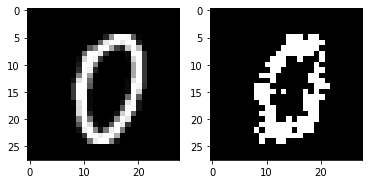

In [9]:
b = data[1000]
b = b.view(1,784)
cpu_b = b
plt.figure()
f,ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(cpu_b.cpu().numpy(),(28,28)),cmap='gray')
new_b = rbm.reconstruct(b)
ax[1].imshow(np.reshape(new_b.cpu().numpy(),(28,28)),cmap='gray')

<Figure size 432x288 with 0 Axes>

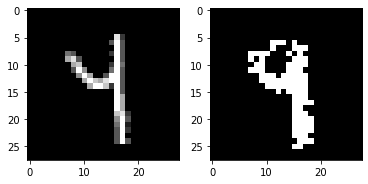

In [10]:
c = data[1004]
c = c.view(1,784)
cpu_c = c
plt.figure()
f,ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(cpu_c.cpu().numpy(),(28,28)),cmap='gray')
new_c = rbm.reconstruct(c)
ax[1].imshow(np.reshape(new_c.cpu().numpy(),(28,28)),cmap='gray')

<Figure size 432x288 with 0 Axes>

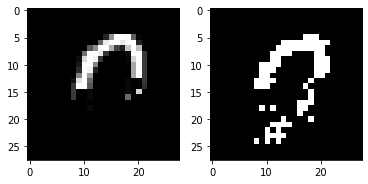

In [12]:
clip_b = [[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  36, 146,
        254, 255, 251,  95,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  97,
        234, 254, 254, 232, 254, 254,  35,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  89,
        140, 254, 254, 174,  67,  33, 200, 254, 190,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        108, 253, 254, 235,  51,   1,   0,   0,  12, 254, 253,  56,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  12, 216, 254, 244,  55,   0,   0,   0,   0,   6, 213, 254,
         57,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  25, 254, 254, 132,   0,   0,   0,   0,   0,   0,
        168, 254,  57,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  45, 254, 243,  34,   0,   0,   0,   0,
          0,   0, 168, 254,  57,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 128, 254, 157,   0,   0,   0,
          0,   0,   0,   0, 168, 254,  57,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  19, 228, 254, 105,   0,
          0,   0,   0,   0,   0,   7, 0, 0,  57,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  58, 254, 254,
         87,   0,   0,   0,   0,   0,   0,  10, 0, 0,  47,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  58,
        0, 0,   9,   0,   0,   0,   0,   0,   0,  10, 0, 210,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  58, 0, 0,   9,   0,   0,   0,   0,   0,   0, 105, 0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  0, 0, 0,   0,   0,   0,   0,   0,   0,  0,
        0, 0,  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 0, 0,   9,   0,   0,   0,   0,
          0,  0, 0, 0,  0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0, 0, 0,  0,   0,   0,
          0,   0,  0, 0, 0,  0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 0, 0, 0,
          0,   0,   0,   0, 0, 0, 0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  0,
        0, 0,  0,   0,   0,  0, 0, 0,  0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  0, 0, 0, 0,  0, 0, 0, 0, 0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  0, 0, 0, 0, 0, 0, 0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 0, 0, 0, 0, 0,  0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]]


clip_b = torch.Tensor(clip_b).to(dev)
cpu_clip_b = clip_b
plt.figure()
f,ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(cpu_clip_b.cpu().numpy(),(28,28)),cmap='gray')
recon_clip_b = rbm.reconstruct(clip_b)
ax[1].imshow(np.reshape(recon_clip_b.cpu().numpy(),(28,28)),cmap='gray')